In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)

In [2]:
learning_rate = 1e-3
eval_iters = 10
batch_size=1000
sequence_len=64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
raw_datasets = load_dataset("code_search_net", "python")
datasets = raw_datasets['train'].filter(lambda x: 'apache/spark' in x['repository_name'])

In [4]:
class char_tokenizer:

    def __init__(self, data):
        # 数据中出现的所有字符构成字典
        chars = sorted(list(set(''.join(data))))
        # 预留一个位置给结尾的特殊字符
        self.char2ind = {s : i + 1 for i, s in enumerate(chars)}
        self.char2ind['<|e|>'] = 0
        self.ind2char = {i : s for s, i in self.char2ind.items()}

    def encode(self, text):
        return [self.char2ind[c] for c in text]

    def decode(self, enc):
        if isinstance(enc, int):
            return self.ind2char[enc]
        return [self.ind2char[i] for i in enc]

tok = char_tokenizer(datasets['whole_func_string'])
len(tok.char2ind)

98

In [5]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x, hidden=None):
        re = []
        # B batch_size,
        # T sequence length,
        # C number of channels.
        B, T, C = x.shape
        x = x.transpose(0, 1) # (T, B, C)
        if hidden is None:
            hidden = self.init_hidden(B, x.device)
        for i in range(T):
            # x[i]: (B, C); hidden: (B, H)
            combined = torch.cat((x[i], hidden), dim=1)
            hidden = F.relu(self.i2h(combined))  # (   B, H)
            re.append(hidden)
        result_tensor = torch.stack(re, dim=0)   # (T, B, H)
        return result_tensor.transpose(0, 1)     # (B, T, H)

    def init_hidden(self, B, device):
        return torch.zeros((B, self.hidden_size), device=device)

class CharRNNBatch(nn.Module):

    def __init__(self, vs):
        super().__init__()
        self.emb_size = 256
        self.hidden_size = 128
        self.embedding = nn.Embedding(vs, self.emb_size)
        self.dp = nn.Dropout(0.4)
        self.rnn1 = RNN(self.emb_size, self.hidden_size)
        self.rnn2 = RNN(self.hidden_size, self.hidden_size)
        self.h2o = nn.Linear(self.hidden_size, vs)

    def forward(self, x):
        # x: (B, T)
        emb = self.embedding(x)      # (B, T,  C)
        h = self.dp(self.rnn1(emb))  # (B, T,  H)
        h = self.dp(self.rnn2(h))    # (B, T,  H)
        output = self.h2o(h)         # (B, T, vs)
        return output

model = CharRNNBatch(len(tok.char2ind)).to(device)

In [6]:
model

CharRNNBatch(
  (embedding): Embedding(98, 256)
  (dp): Dropout(p=0.4, inplace=False)
  (rnn1): RNN(
    (i2h): Linear(in_features=384, out_features=128, bias=True)
  )
  (rnn2): RNN(
    (i2h): Linear(in_features=256, out_features=128, bias=True)
  )
  (h2o): Linear(in_features=128, out_features=98, bias=True)
)

In [7]:
@torch.no_grad()
def generate_batch(model, idx, max_new_tokens=300):
    # 将模型切换至评估模式
    model.eval()
    for _ in range(max_new_tokens):
        # 限制背景长度，使之与模型训练时的状况更相符
        # 当然也可以不限制
        context = idx[:, -sequence_len:]
        # 在文本生成时，模型的计算效率很低，因为有很多重复计算
        logits = model(context)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, ix), dim=1)
        if ix.item() == 0:
            break
    # 将模型切换至训练模式
    model.train()
    return idx.tolist()[0]

In [8]:
begin_text = torch.tensor(tok.encode('def'), device=device).unsqueeze(0)
print(''.join(tok.decode(generate_batch(model, begin_text))))

def*ZO(F/of("YP{BZE G|uw=3:1'_$?Q9NN[{KQ=CK(AM:iKcaR;+Q3j<sAegWS$ö0Nx!qyT3"yMm5Za)'W~5\Wm&B"({r
cdtMh^DA11zc<|e|>


In [9]:
def process(data, sequence_len=sequence_len):
    text = data['whole_func_string']
    inputs, labels = [], []
    for i in text:
        enc = tok.encode(i)
        # 0对应着文本结束
        enc += [0]
        for i in range(len(enc) - sequence_len):
            inputs.append(enc[i: i + sequence_len])
            labels.append(enc[i + 1: i + 1 + sequence_len])
    return {'inputs': inputs, 'labels': labels}

tokenized = datasets.train_test_split(test_size=0.1, seed=1024, shuffle=True)
tokenized = tokenized.map(process, batched=True, remove_columns=datasets.column_names)
tokenized.set_format(type='torch', device=device)

tokenized['train']['inputs'].shape, tokenized['train']['labels'].shape

(torch.Size([605913, 64]), torch.Size([605913, 64]))

In [10]:
# 构建数据读取器
train_loader = DataLoader(tokenized['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tokenized['test'], batch_size=batch_size, shuffle=True)
# 获取一个批量的数据
next(iter(test_loader))

{'inputs': tensor([[16, 76, 85,  ..., 69, 67, 80],
         [ 2,  2,  2,  ..., 71, 72, 71],
         [89, 37, 81,  ..., 70, 40, 75],
         ...,
         [76, 71, 69,  ...,  2,  2,  2],
         [ 2, 19,  1,  ..., 74, 67, 86],
         [48, 81, 84,  ..., 78,  2, 70]], device='cuda:0'),
 'labels': tensor([[76, 85, 81,  ..., 67, 80,  2],
         [ 2,  2,  2,  ..., 72, 71, 84],
         [37, 81, 79,  ..., 40, 75, 71],
         ...,
         [71, 69, 86,  ...,  2,  2,  2],
         [19,  1,  2,  ..., 67, 86,  2],
         [81, 84, 79,  ...,  2, 70, 75]], device='cuda:0')}

In [11]:
def estimate_loss(model):
    re = {}
    # 将模型切换至评估模式
    model.eval()
    _train = lambda: next(iter(train_loader))
    re['train'] = _loss(model, _train)
    _test = lambda: next(iter(test_loader))
    re['test'] = _loss(model, _test)
    # 将模型切换至训练模式
    model.train()
    return re

@torch.no_grad()
def _loss(model, data_loader):
    """
    计算模型在不同数据集下面的评估指标
    """
    loss = []
    for k in range(eval_iters):
        data = data_loader()
        inputs, labels = data['inputs'], data['labels']
        logits = model(inputs)
        logits = logits.transpose(-2, -1)
        loss.append(F.cross_entropy(logits, labels).item())
    return torch.tensor(loss).mean().item()

estimate_loss(model)

{'train': 4.5722737312316895, 'test': 4.5736470222473145}

In [12]:
def train_rnn(model, optimizer, data_loader, epochs=10):
    lossi = []
    for epoch in range(epochs):
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data['inputs'], data['labels']
            optimizer.zero_grad()
            logits = model(inputs)
            logits = logits.transpose(-2, -1)
            loss = F.cross_entropy(logits, labels)
            lossi.append(loss.item())
            loss.backward()
            optimizer.step()
        # 评估模型，并输出结果
        stats = estimate_loss(model)
        train_loss = f'train loss {stats["train"]:.4f}'
        test_loss = f'test loss {stats["test"]:.4f}'
        print(f'epoch {epoch:>2}: {train_loss}, {test_loss}')
    return lossi

In [13]:
l = train_rnn(model, optim.Adam(model.parameters(), lr=learning_rate), train_loader)

epoch  0: train loss 1.4958, test loss 1.6121
epoch  1: train loss 1.3703, test loss 1.4883
epoch  2: train loss 1.3150, test loss 1.4406
epoch  3: train loss 1.2851, test loss 1.4160
epoch  4: train loss 1.2645, test loss 1.4023
epoch  5: train loss 1.2545, test loss 1.3954
epoch  6: train loss 1.2403, test loss 1.3771
epoch  7: train loss 1.2358, test loss 1.3824
epoch  8: train loss 1.2180, test loss 1.3689
epoch  9: train loss 1.2146, test loss 1.3682


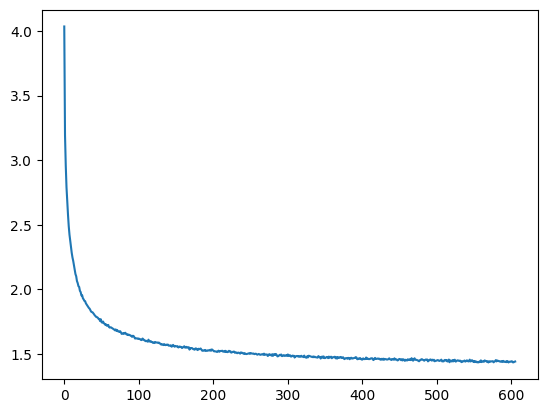

In [14]:
plt.plot(torch.tensor(l).view(-1, 10).mean(1).numpy())

In [15]:
begin_text = torch.tensor(tok.encode('def'), device=device).unsqueeze(0)
print(''.join(tok.decode(generate_batch(model, begin_text))))

def name=(dezer==5.0,
                "filed (preract(nullable)|               not numPartitions((_kenagi=<htr-minthor(3, 0'3
    [2, 2,, ]

        func(iper_tobupiel(rrort.gatewervalt, schissConf()
            obj aw 5.0.0
        >>> pValeed(dataFrom_j2iek,'},('d)|.e.iriod())
                if jsfd
